In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

import graphviz
from graphviz import Source

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('merged_weather_trips.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688882 entries, 0 to 688881
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   rain             688882 non-null  float64
 1   temp             688882 non-null  float64
 2   is_raining       688882 non-null  int64  
 3   freezing         688882 non-null  int64  
 4   DAYOFSERVICE     688882 non-null  object 
 5   HOUR             688882 non-null  int64  
 6   TRIPID           688882 non-null  int64  
 7   LINEID           688882 non-null  object 
 8   ROUTEID          688882 non-null  object 
 9   DIRECTION        688882 non-null  int64  
 10  PLANNEDTIME_ARR  688882 non-null  float64
 11  PLANNEDTIME_DEP  688882 non-null  float64
 12  ACTUALTIME_ARR   688882 non-null  float64
 13  ACTUALTIME_DEP   688882 non-null  float64
dtypes: float64(6), int64(5), object(3)
memory usage: 73.6+ MB


In [4]:
df = df[['DAYOFSERVICE','HOUR','TRIPID','LINEID','ROUTEID','DIRECTION','PLANNEDTIME_ARR','PLANNEDTIME_DEP','ACTUALTIME_ARR','ACTUALTIME_DEP','rain','temp','is_raining','freezing']]
df

,DAYOFSERVICE,HOUR,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,rain,temp,is_raining,freezing
0,2018-01-02,0,5963431,65,65_75,2,91213.0,87300.0,90458.0,87314.0,0.0,3.8,0,0
1,2018-01-02,5,5963422,65,65_73,1,23878.0,19800.0,24834.0,20409.0,0.0,5.2,0,0
2,2018-01-02,5,5962263,40,40_31,2,26069.0,21600.0,26163.0,21589.0,0.0,5.2,0,0
3,2018-01-02,5,5963304,40,40_31,2,25469.0,21000.0,25110.0,21004.0,0.0,5.2,0,0
4,2018-01-02,6,5961178,14,14_15,1,26508.0,22500.0,26011.0,22497.0,0.5,5.8,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688877,2018-12-31,22,8589536,120,120_12,1,80376.0,79200.0,80529.0,79202.0,0.0,9.9,0,0
688878,2018-12-31,22,8586917,27B,27B_34,2,81049.0,78900.0,81634.0,79246.0,0.0,9.9,0,0
688879,2018-12-31,22,8582081,32,32_58,2,81987.0,80100.0,81577.0,79482.0,0.0,9.9,0,0
688880,2018-12-31,22,8584078,25A,25A_273,1,81636.0,79320.0,81983.0,79238.0,0.0,9.9,0,0


In [5]:
df['PLANNED_TRIPTIME'] = df['PLANNEDTIME_ARR']-df['PLANNEDTIME_DEP']
df['ACTUAL_TRIPTIME'] = df['ACTUALTIME_ARR']-df['ACTUALTIME_DEP']
df['DIFFERENCE_TRIPTIME'] = df['ACTUAL_TRIPTIME']-df['PLANNED_TRIPTIME']

In [6]:
df['EARLY_LATE'] = pd.Series(dtype='string')

In [7]:
df.loc[df['DIFFERENCE_TRIPTIME']>0, ['EARLY_LATE']] = 'LATE'
df.loc[df['DIFFERENCE_TRIPTIME']<0, ['EARLY_LATE']] = 'EARLY'
df.loc[df['DIFFERENCE_TRIPTIME']==0, ['EARLY_LATE']] = 'ONTIME'

In [8]:
df

,DAYOFSERVICE,HOUR,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,rain,temp,is_raining,freezing,PLANNED_TRIPTIME,ACTUAL_TRIPTIME,DIFFERENCE_TRIPTIME,EARLY_LATE
0,2018-01-02,0,5963431,65,65_75,2,91213.0,87300.0,90458.0,87314.0,0.0,3.8,0,0,3913.0,3144.0,-769.0,EARLY
1,2018-01-02,5,5963422,65,65_73,1,23878.0,19800.0,24834.0,20409.0,0.0,5.2,0,0,4078.0,4425.0,347.0,LATE
2,2018-01-02,5,5962263,40,40_31,2,26069.0,21600.0,26163.0,21589.0,0.0,5.2,0,0,4469.0,4574.0,105.0,LATE
3,2018-01-02,5,5963304,40,40_31,2,25469.0,21000.0,25110.0,21004.0,0.0,5.2,0,0,4469.0,4106.0,-363.0,EARLY
4,2018-01-02,6,5961178,14,14_15,1,26508.0,22500.0,26011.0,22497.0,0.5,5.8,1,0,4008.0,3514.0,-494.0,EARLY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688877,2018-12-31,22,8589536,120,120_12,1,80376.0,79200.0,80529.0,79202.0,0.0,9.9,0,0,1176.0,1327.0,151.0,LATE
688878,2018-12-31,22,8586917,27B,27B_34,2,81049.0,78900.0,81634.0,79246.0,0.0,9.9,0,0,2149.0,2388.0,239.0,LATE
688879,2018-12-31,22,8582081,32,32_58,2,81987.0,80100.0,81577.0,79482.0,0.0,9.9,0,0,1887.0,2095.0,208.0,LATE
688880,2018-12-31,22,8584078,25A,25A_273,1,81636.0,79320.0,81983.0,79238.0,0.0,9.9,0,0,2316.0,2745.0,429.0,LATE


In [9]:
df['EARLY_LATE'].unique()

<StringArray>
['EARLY', 'LATE', 'ONTIME']
Length: 3, dtype: string

In [10]:
df.loc[df['EARLY_LATE'] == 'ONTIME']

,DAYOFSERVICE,HOUR,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,rain,temp,is_raining,freezing,PLANNED_TRIPTIME,ACTUAL_TRIPTIME,DIFFERENCE_TRIPTIME,EARLY_LATE
421,2018-01-02,9,5962144,130,130_11,2,37489.0,35700.0,37472.0,35683.0,0.5,8.9,1,0,1789.0,1789.0,0.0,ONTIME
1342,2018-01-02,17,5968116,27B,27B_34,2,65227.0,62100.0,65348.0,62221.0,0.4,8.2,1,0,3127.0,3127.0,0.0,ONTIME
1492,2018-01-02,19,5969155,14,14_15,1,75771.0,72000.0,75752.0,71981.0,0.0,11.0,0,0,3771.0,3771.0,0.0,ONTIME
1593,2018-01-02,20,5966776,9,9_5,1,79088.0,75600.0,79065.0,75577.0,0.0,9.4,0,0,3488.0,3488.0,0.0,ONTIME
2015,2018-01-03,7,5958955,63,63_28,2,30161.0,27900.0,30150.0,27889.0,0.2,6.5,1,0,2261.0,2261.0,0.0,ONTIME
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685737,2018-12-31,9,8581496,120,120_13,2,35559.0,34200.0,35573.0,34214.0,0.0,9.8,0,0,1359.0,1359.0,0.0,ONTIME
685969,2018-12-31,10,8584939,26,26_29,2,38926.0,37200.0,38868.0,37142.0,0.0,9.9,0,0,1726.0,1726.0,0.0,ONTIME
686632,2018-12-31,12,8592114,7A,7A_87,2,48149.0,44100.0,48039.0,43990.0,0.0,10.4,0,0,4049.0,4049.0,0.0,ONTIME
686744,2018-12-31,13,8580927,130,130_10,1,51060.0,49500.0,50993.0,49433.0,0.0,10.3,0,0,1560.0,1560.0,0.0,ONTIME


## Review, Prep and Split

In [11]:
df.isna().sum()

DAYOFSERVICE           0
HOUR                   0
TRIPID                 0
LINEID                 0
ROUTEID                0
DIRECTION              0
PLANNEDTIME_ARR        0
PLANNEDTIME_DEP        0
ACTUALTIME_ARR         0
ACTUALTIME_DEP         0
rain                   0
temp                   0
is_raining             0
freezing               0
PLANNED_TRIPTIME       0
ACTUAL_TRIPTIME        0
DIFFERENCE_TRIPTIME    0
EARLY_LATE             0
dtype: int64

In [12]:
df.dtypes

DAYOFSERVICE            object
HOUR                     int64
TRIPID                   int64
LINEID                  object
ROUTEID                 object
DIRECTION                int64
PLANNEDTIME_ARR        float64
PLANNEDTIME_DEP        float64
ACTUALTIME_ARR         float64
ACTUALTIME_DEP         float64
rain                   float64
temp                   float64
is_raining               int64
freezing                 int64
PLANNED_TRIPTIME       float64
ACTUAL_TRIPTIME        float64
DIFFERENCE_TRIPTIME    float64
EARLY_LATE              string
dtype: object

In [13]:
# CONVERT DTYPES FOR PLOTTING LATER
df['EARLY_LATE'] = df['EARLY_LATE'].map({'EARLY': 0, "ONTIME": 1, 'LATE':2})

In [14]:
df['DAYOFSERVICE'] = pd.to_datetime(df['DAYOFSERVICE'])

In [15]:
df.describe(datetime_is_numeric=True).T 

,count,mean,min,25%,50%,75%,max,std
DAYOFSERVICE,688882,2018-06-23 19:21:05.253555200,2018-01-02 00:00:00,2018-03-26 00:00:00,2018-06-23 00:00:00,2018-09-23 00:00:00,2018-12-31 00:00:00,NaN
HOUR,688882.0,13.779867,0.0,10.0,14.0,18.0,23.0,4.851129
TRIPID,688882.0,7132692.55588,5955221.0,6414928.75,7029777.5,7788574.0,8592207.0,750445.926301
DIRECTION,688882.0,1.498691,1.0,1.0,1.0,2.0,2.0,0.499999
PLANNEDTIME_ARR,688882.0,54864.68347,18403.0,39769.0,54852.0,68635.0,91680.0,17247.440243
PLANNEDTIME_DEP,688882.0,51358.769833,16200.0,36000.0,51300.0,64800.0,87600.0,17396.848694
ACTUALTIME_ARR,688882.0,55233.680093,17854.0,40064.0,55260.0,69058.75,92421.0,17244.682941
ACTUALTIME_DEP,688882.0,51394.922606,16187.0,36234.0,51266.0,64842.0,88993.0,17402.074669
rain,688882.0,0.053168,0.0,0.0,0.0,0.0,8.6,0.289991
temp,688882.0,11.398091,-3.0,7.1,11.1,15.7,27.5,5.763468


In [16]:
categorical_cols = df.select_dtypes(['object']).columns
categorical_cols = categorical_cols.append(df[['HOUR','TRIPID', 'DIRECTION', 'is_raining', 'freezing', 'EARLY_LATE']].columns)
# convert columns in the list to categorical columns
for col in categorical_cols:
    df[col] = df[col].astype('category')
df.dtypes

DAYOFSERVICE           datetime64[ns]
HOUR                         category
TRIPID                       category
LINEID                       category
ROUTEID                      category
DIRECTION                    category
PLANNEDTIME_ARR               float64
PLANNEDTIME_DEP               float64
ACTUALTIME_ARR                float64
ACTUALTIME_DEP                float64
rain                          float64
temp                          float64
is_raining                   category
freezing                     category
PLANNED_TRIPTIME              float64
ACTUAL_TRIPTIME               float64
DIFFERENCE_TRIPTIME           float64
EARLY_LATE                   category
dtype: object

In [17]:
df[['PLANNEDTIME_ARR','PLANNEDTIME_DEP','ACTUALTIME_ARR','ACTUALTIME_DEP','PLANNED_TRIPTIME','ACTUAL_TRIPTIME','DIFFERENCE_TRIPTIME']] = df[['PLANNEDTIME_ARR','PLANNEDTIME_DEP','ACTUALTIME_ARR','ACTUALTIME_DEP','PLANNED_TRIPTIME','ACTUAL_TRIPTIME','DIFFERENCE_TRIPTIME']].astype('int64')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688882 entries, 0 to 688881
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   DAYOFSERVICE         688882 non-null  datetime64[ns]
 1   HOUR                 688882 non-null  category      
 2   TRIPID               688882 non-null  category      
 3   LINEID               688882 non-null  category      
 4   ROUTEID              688882 non-null  category      
 5   DIRECTION            688882 non-null  category      
 6   PLANNEDTIME_ARR      688882 non-null  int64         
 7   PLANNEDTIME_DEP      688882 non-null  int64         
 8   ACTUALTIME_ARR       688882 non-null  int64         
 9   ACTUALTIME_DEP       688882 non-null  int64         
 10  rain                 688882 non-null  float64       
 11  temp                 688882 non-null  float64       
 12  is_raining           688882 non-null  category      
 13  freezing      

In [19]:
continuous_cols = df.select_dtypes(['float64','datetime64[ns]','int64']).columns


In [20]:
df.duplicated().value_counts()

False    688882
dtype: int64

In [21]:
df.nunique()

DAYOFSERVICE              255
HOUR                       21
TRIPID                 358406
LINEID                    130
ROUTEID                   583
DIRECTION                   2
PLANNEDTIME_ARR         62856
PLANNEDTIME_DEP           790
ACTUALTIME_ARR          65885
ACTUALTIME_DEP          63829
rain                       34
temp                      288
is_raining                  2
freezing                    2
PLANNED_TRIPTIME         6307
ACTUAL_TRIPTIME          8666
DIFFERENCE_TRIPTIME      6083
EARLY_LATE                  3
dtype: int64

## Shuffle and split

In [22]:
# randomly generate sequence based on dataframe index and set to be new index
df.set_index(np.random.permutation(df.index))
# sort the resulting random index
df.sort_index(inplace=True)
df.head()

,DAYOFSERVICE,HOUR,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,rain,temp,is_raining,freezing,PLANNED_TRIPTIME,ACTUAL_TRIPTIME,DIFFERENCE_TRIPTIME,EARLY_LATE
0,2018-01-02,0,5963431,65,65_75,2,91213,87300,90458,87314,0.0,3.8,0,0,3913,3144,-769,0
1,2018-01-02,5,5963422,65,65_73,1,23878,19800,24834,20409,0.0,5.2,0,0,4078,4425,347,2
2,2018-01-02,5,5962263,40,40_31,2,26069,21600,26163,21589,0.0,5.2,0,0,4469,4574,105,2
3,2018-01-02,5,5963304,40,40_31,2,25469,21000,25110,21004,0.0,5.2,0,0,4469,4106,-363,0
4,2018-01-02,6,5961178,14,14_15,1,26508,22500,26011,22497,0.5,5.8,1,0,4008,3514,-494,0


In [23]:
y = pd.DataFrame(df["DIFFERENCE_TRIPTIME"])
X = df.drop(columns=["DIFFERENCE_TRIPTIME"],axis=1)

In [24]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  688882
training range (70%):	 rows 0 to 482217
test range (30%): 	 rows 482217 to 688882


In [27]:
continuous_cols = X_train.select_dtypes(['int64','float64','datetime64[ns]']).columns


### plot correlations on training set
#### continuous features

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'PLANNEDTIME_ARR'),
  Text(1.5, 0, 'PLANNEDTIME_DEP'),
  Text(2.5, 0, 'ACTUALTIME_ARR'),
  Text(3.5, 0, 'ACTUALTIME_DEP'),
  Text(4.5, 0, 'rain'),
  Text(5.5, 0, 'temp'),
  Text(6.5, 0, 'PLANNED_TRIPTIME'),
  Text(7.5, 0, 'ACTUAL_TRIPTIME')])

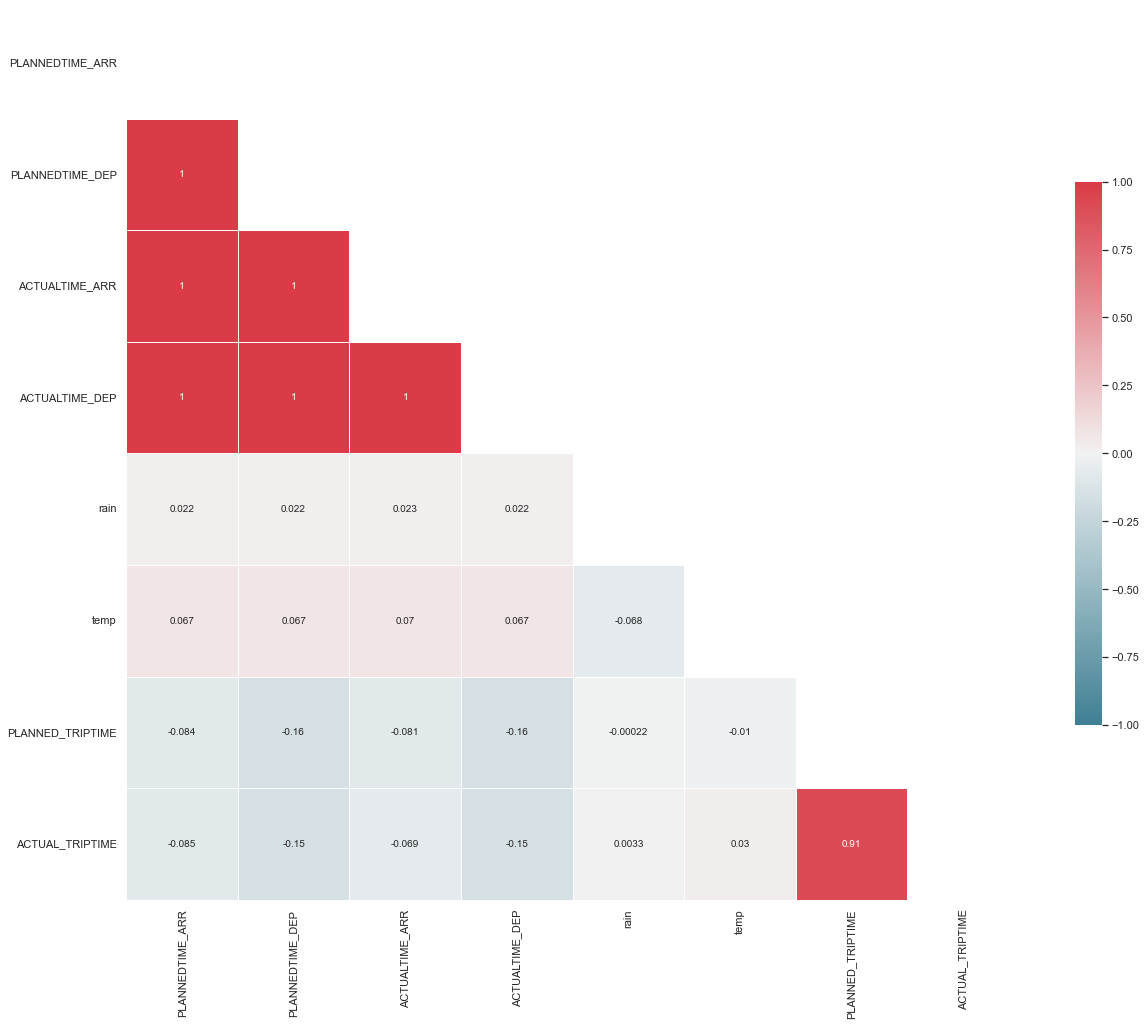

In [28]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = X_train[continuous_cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

In [30]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_train[continuous_cols]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "DIFFERENCE_TRIPTIME"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="DIFFERENCE_TRIPTIME", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['DIFFERENCE_TRIPTIME']).sort_values('DIFFERENCE_TRIPTIME', ascending=False)
corr_df

IndexError: index 1 is out of bounds for axis 1 with size 1